In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
        
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="seaborn")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/abalone-dataset/abalone.csv


In [2]:
df = pd.read_csv("/kaggle/input/abalone-dataset/abalone.csv")
df.columns = [col.replace(' ', '_') for col in df.columns]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [3]:
df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [4]:
numeric_features = df.select_dtypes(include=np.number).columns

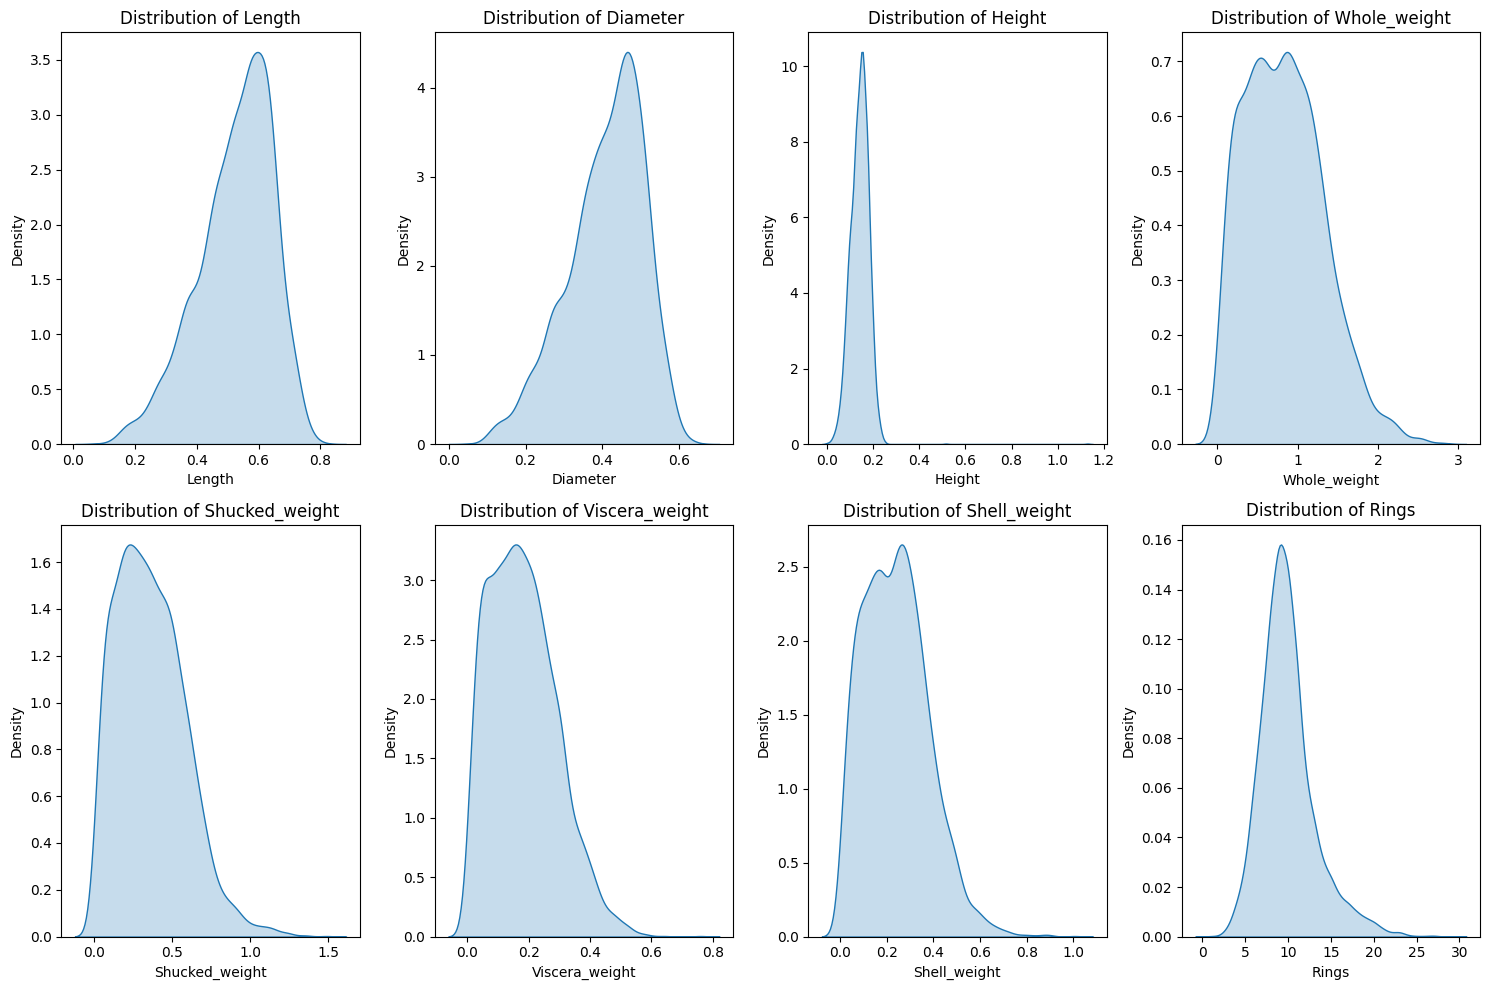

In [5]:
num_plots_per_row = 4
num_features = len(numeric_features)
num_rows = (num_features + num_plots_per_row - 1) // num_plots_per_row 

plt.figure(figsize=(15, 5 * num_rows))
for idx, feature in enumerate(numeric_features):
    plt.subplot(num_rows, num_plots_per_row, idx + 1)
    sns.kdeplot(df[feature], fill=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [6]:
df = pd.get_dummies(df, columns = ['Sex'])

# Modelling

In [7]:
from sklearn.ensemble import GradientBoostingRegressor,  RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree as plot_sklearn_tree

In [8]:
y = df["Rings"]
X = df.drop(["Rings"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## RandomForestRegressor

In [9]:
param_grid = {
    'n_estimators': [101],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

rf_score = cross_val_score(rf, X_test, y_test, cv = 3, scoring = 'neg_root_mean_squared_error')
print("Test precision:", round(-rf_score.mean(), 4))

rf_error = rf.predict(X_test) - y_test

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 101}
Test precision: 2.2899


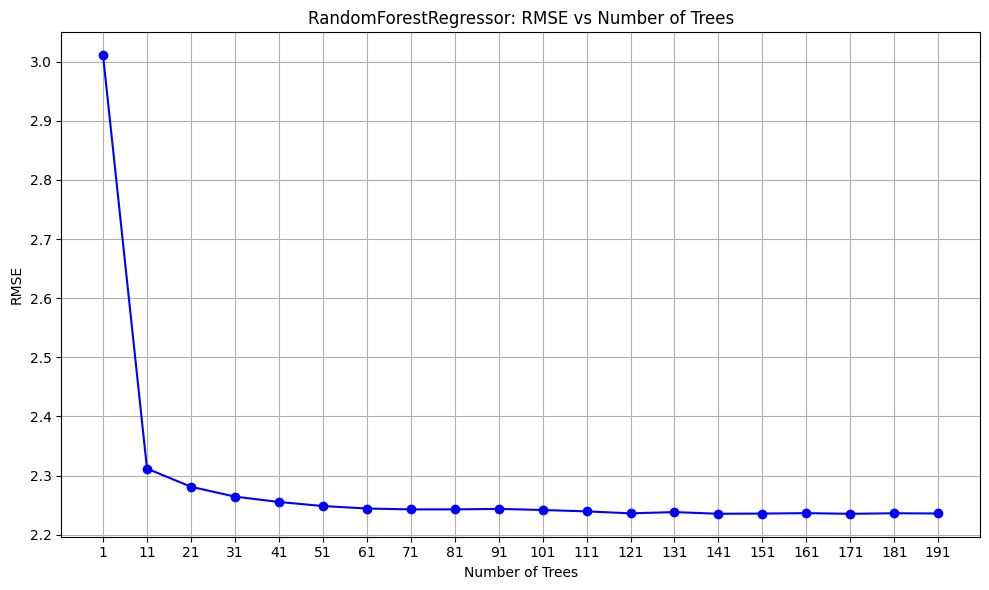

In [10]:
n_estimators_range = range(1, 201, 10)

rmse_values = []
for n_estimators in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n_estimators, verbose=0, random_state=123)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rmse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('RandomForestRegressor: RMSE vs Number of Trees')
plt.xticks(n_estimators_range)
plt.grid(True)
plt.tight_layout()
plt.show()

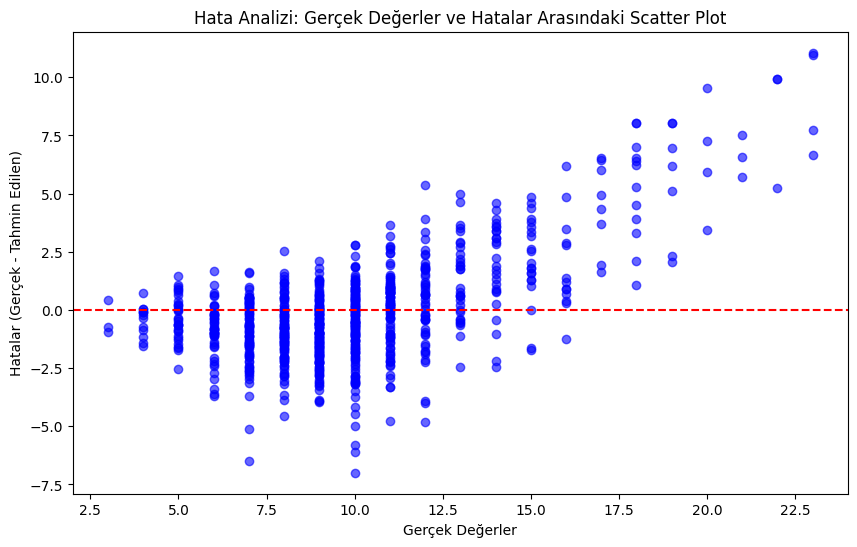

In [11]:
errors = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.6, color='b') 
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Hata Analizi: Gerçek Değerler ve Hatalar Arasındaki Scatter Plot')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Hatalar (Gerçek - Tahmin Edilen)')
plt.show()

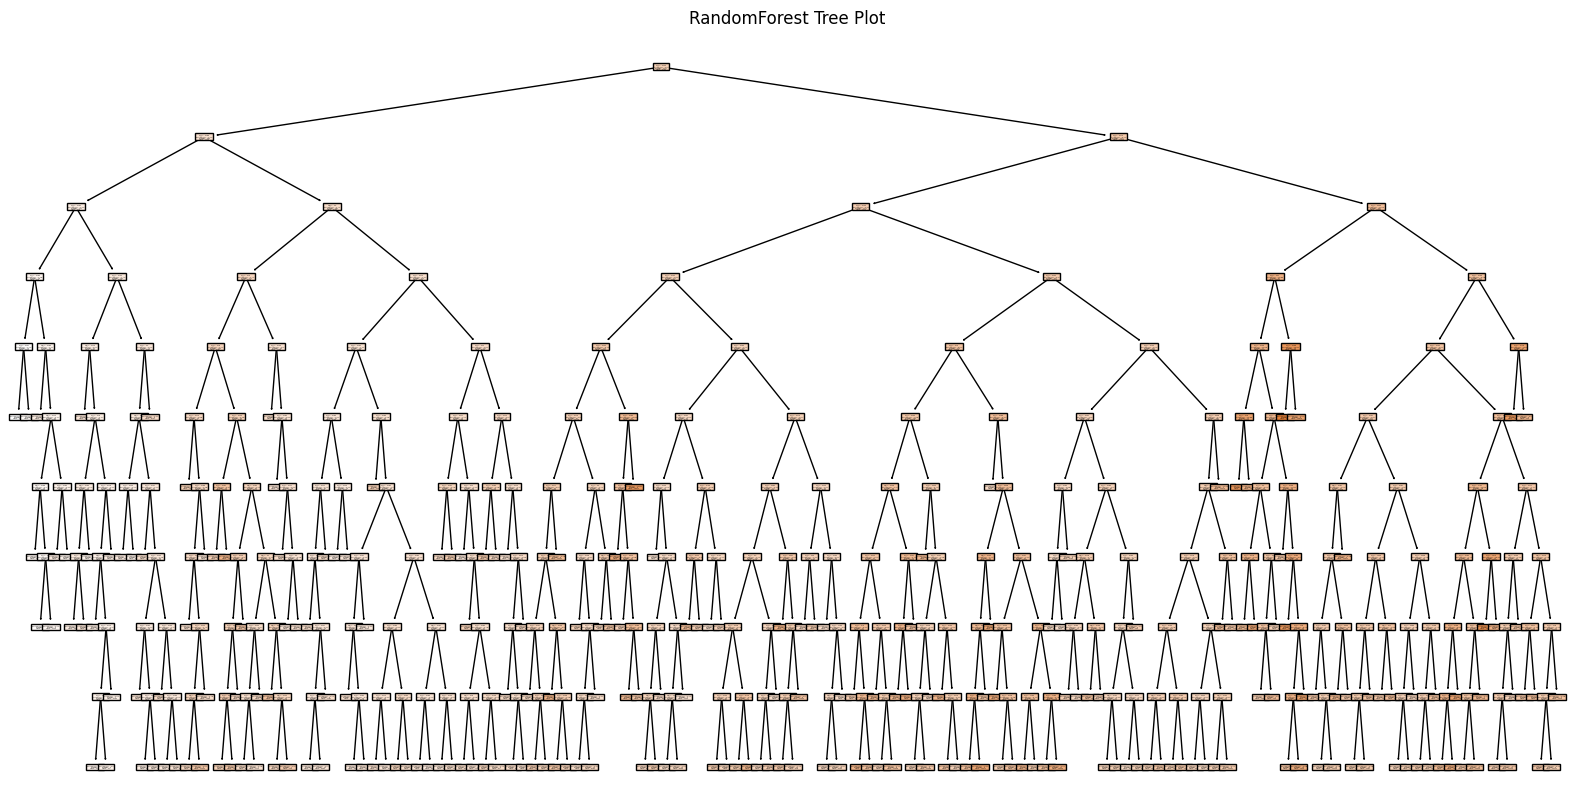

In [12]:
plt.figure(figsize=(20, 10))
plot_sklearn_tree(rf.estimators_[0], filled=True)
plt.title("RandomForest Tree Plot")
plt.show()

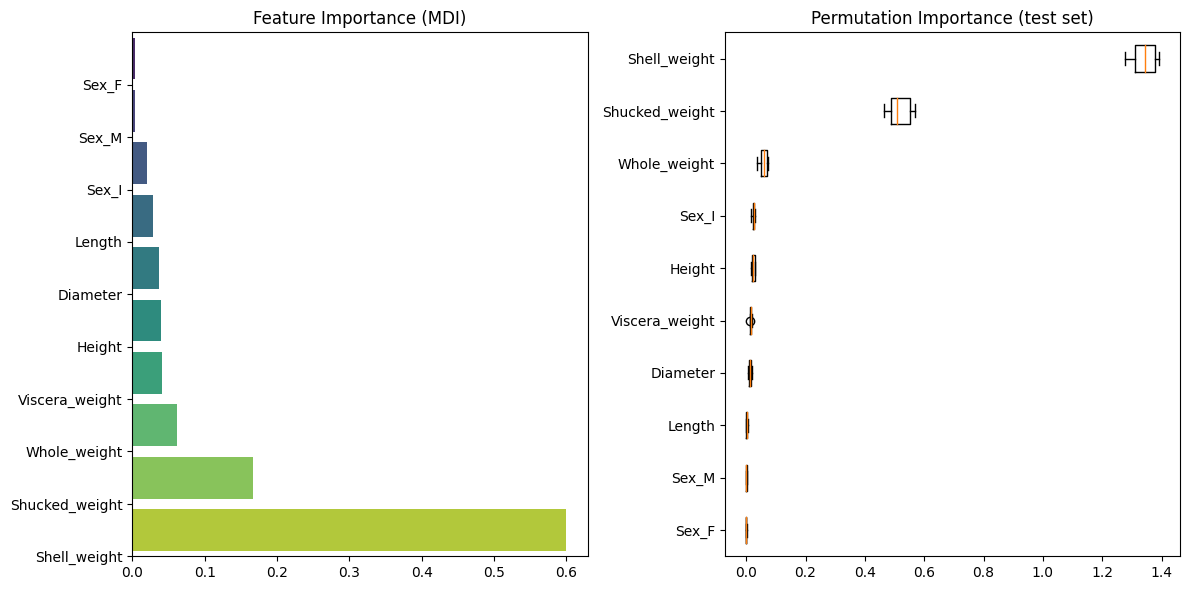

In [13]:
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=feature_importance[sorted_idx], y=np.array(X_train.columns)[sorted_idx], orient='h', palette='viridis')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## GradientBoostingRegressor

In [14]:
param_grid = {
    'n_estimators': [91],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2],
    'min_samples_split': [2],
    'min_samples_leaf': [17]
}

gbr = GradientBoostingRegressor(random_state=123)

grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid, cv = 3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

gbr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

gbr_score = cross_val_score(gbr, X_test, y_test, cv = 3, scoring = 'neg_root_mean_squared_error')
print("Test precision:", round(-gbr_score.mean(), 4))

gbr_error = gbr.predict(X_test) - y_test

Best Parameters: {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 17, 'min_samples_split': 2, 'n_estimators': 91}
Test precision: 2.3241


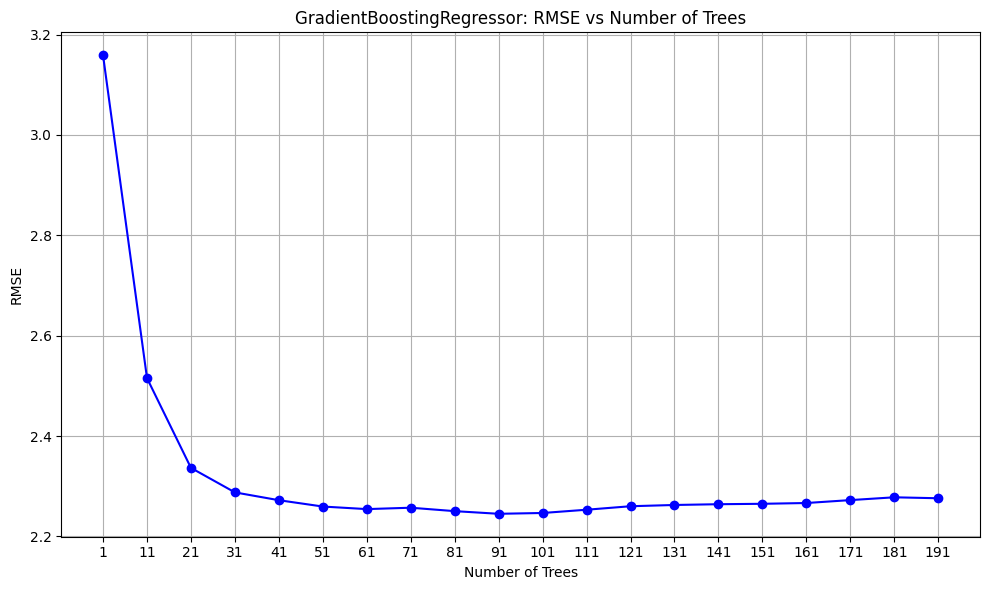

In [15]:
n_estimators_range = range(1, 201, 10)

rmse_values = []
for n_estimators in n_estimators_range:
    model = GradientBoostingRegressor(n_estimators=n_estimators, verbose=0, random_state=123)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rmse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('GradientBoostingRegressor: RMSE vs Number of Trees')
plt.xticks(n_estimators_range)
plt.grid(True)
plt.tight_layout()
plt.show()

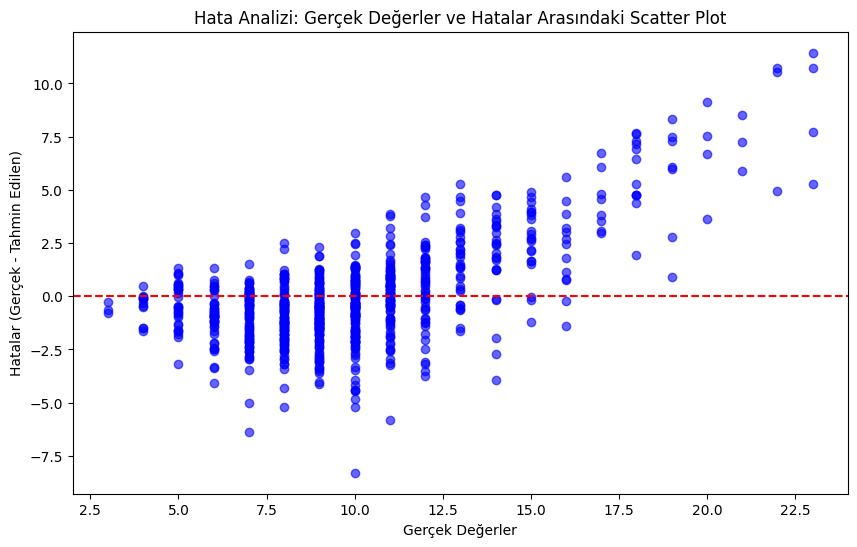

In [16]:
errors = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.6, color='b') 
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Hata Analizi: Gerçek Değerler ve Hatalar Arasındaki Scatter Plot')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Hatalar (Gerçek - Tahmin Edilen)')
plt.show()

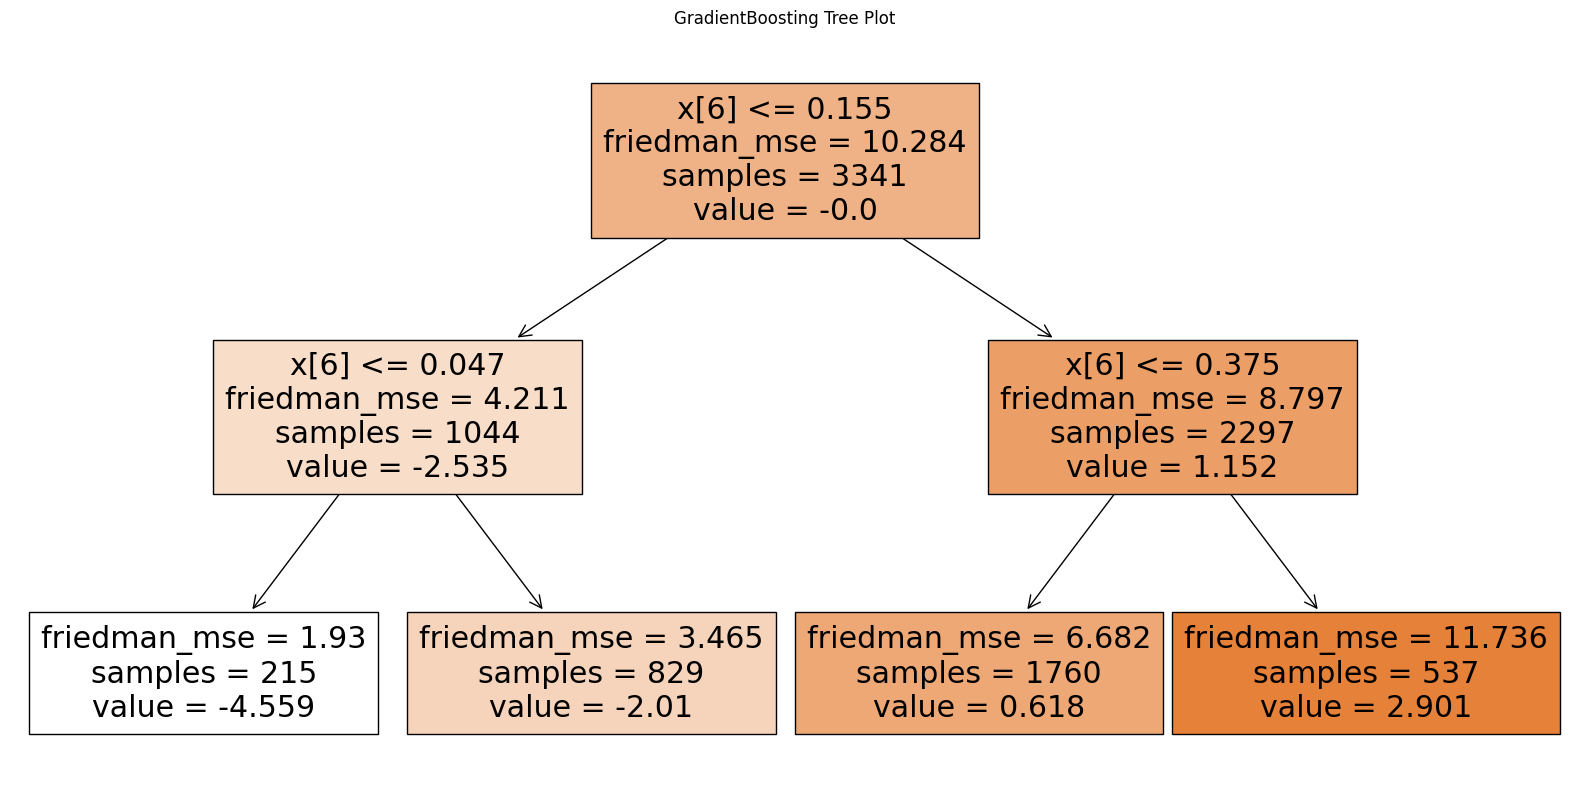

In [17]:
plt.figure(figsize=(20, 10))
plot_sklearn_tree(gbr.estimators_[0, 0], filled=True)  
plt.title("GradientBoosting Tree Plot")
plt.show()


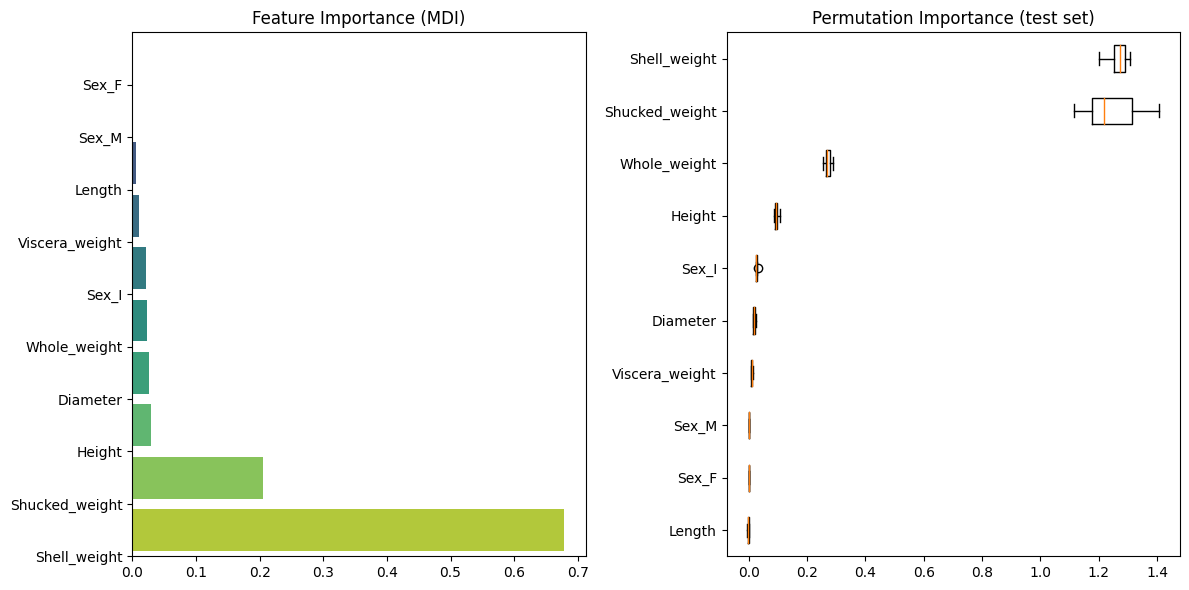

In [18]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=feature_importance[sorted_idx], y=np.array(X_train.columns)[sorted_idx], orient='h', palette='viridis')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## ExtraTreesRegressor

In [19]:
param_grid = {
    'n_estimators': [81],
    'learning_rate': [0.05],
    'max_depth': [12],
    'min_samples_split': [20],
    'min_samples_leaf': [20]
}

extr = GradientBoostingRegressor(random_state=123)

grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid, cv = 3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

extr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

extr_score = cross_val_score(extr, X_test, y_test, cv = 3, scoring = 'neg_root_mean_squared_error')
print("Test precision:", round(-extr_score.mean(), 4))

extr_error = extr.predict(X_test) - y_test

Best Parameters: {'learning_rate': 0.05, 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 81}
Test precision: 2.3035


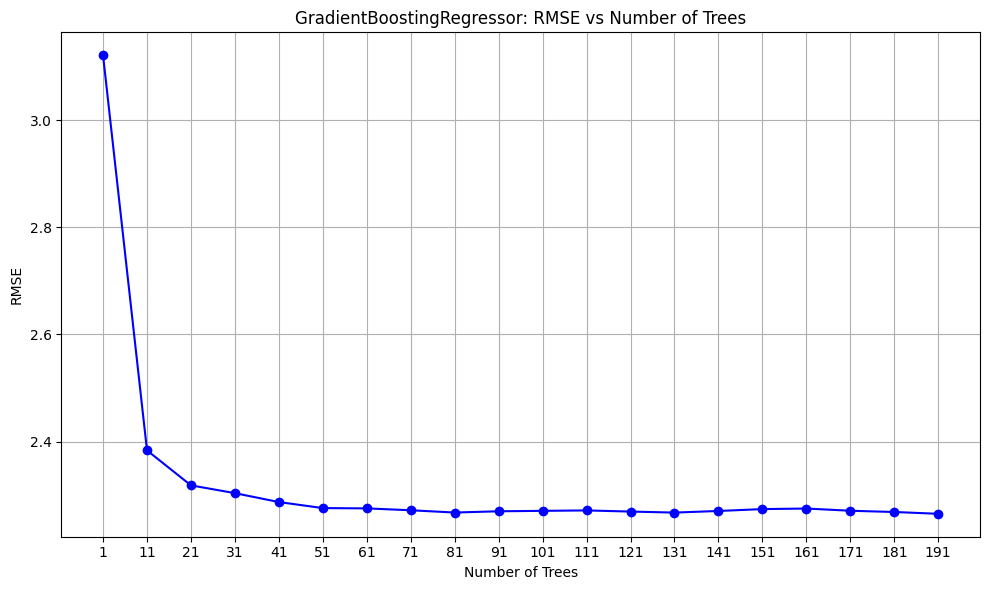

In [20]:
n_estimators = range(1, 200, 10)

rmse_values = []
for n_estimators in n_estimators_range:
    model = ExtraTreesRegressor(n_estimators=n_estimators, verbose=0, random_state=123)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rmse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('GradientBoostingRegressor: RMSE vs Number of Trees')
plt.xticks(n_estimators_range)
plt.grid(True)
plt.tight_layout()
plt.show()

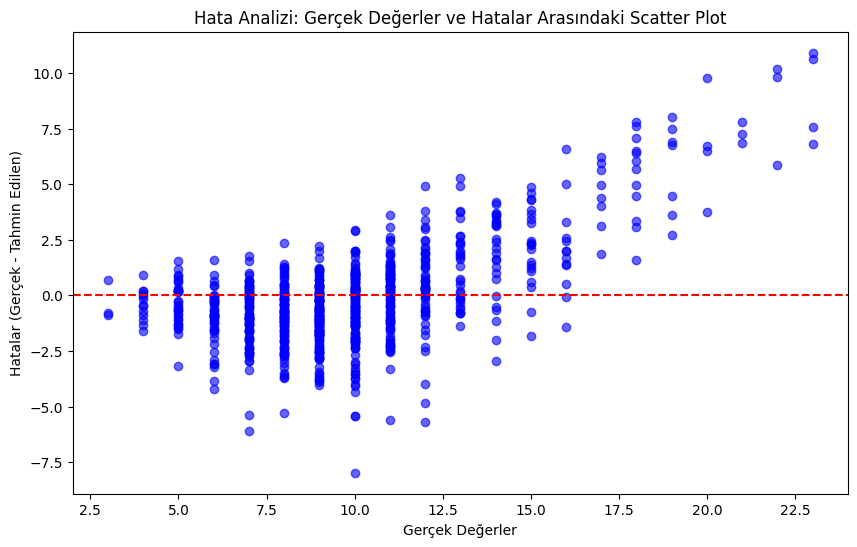

In [21]:
errors = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.6, color='b') 
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Hata Analizi: Gerçek Değerler ve Hatalar Arasındaki Scatter Plot')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Hatalar (Gerçek - Tahmin Edilen)')
plt.show()

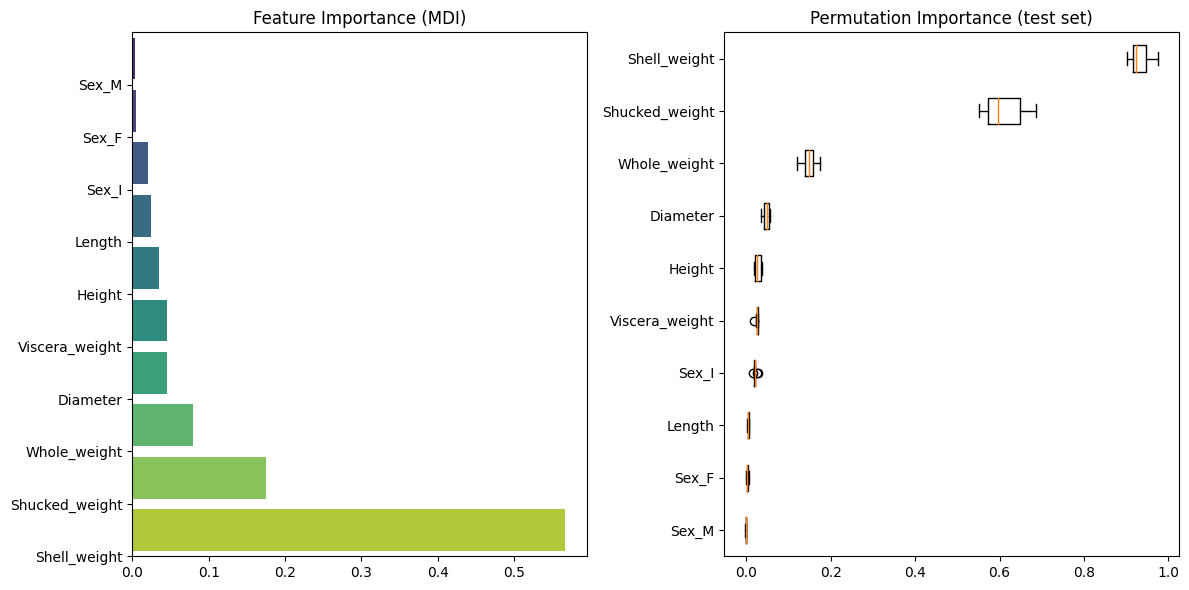

In [22]:
feature_importance = extr.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=feature_importance[sorted_idx], y=np.array(X_train.columns)[sorted_idx], orient='h', palette='viridis')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    extr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## LGBMRegressor

In [23]:
lgb = LGBMRegressor()

param_grid={"num_leaves":[10,20,30,45],
            "max_depth" :[-1,5,10,15],
            "learning_rate":[0.01,0.05,1],
            "n_estimators":[20,50,80,100,120],
            "random_state":[123],
            "metric":["root_mean_squared_error"],
            "verbose":[-1]
             }
param_grid={"n_estimators":[50] ,"num_leaves":[10], "max_depth" :[5], "learning_rate":[0.05], "n_estimators":[100], "random_state":[123], "metric":["root_mean_squared_error"], "verbose":[-1]}

grid_search = GridSearchCV(estimator = lgb, param_grid = param_grid, cv = 3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

lgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

lgb_score = cross_val_score(lgb, X_test, y_test, cv = 3, scoring = 'neg_root_mean_squared_error')
print("Test precision:", round(-lgb_score.mean(), 4))

lgb_error = lgb.predict(X_test) - y_test

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'metric': 'root_mean_squared_error', 'n_estimators': 100, 'num_leaves': 10, 'random_state': 123, 'verbose': -1}
Test precision: 2.3031


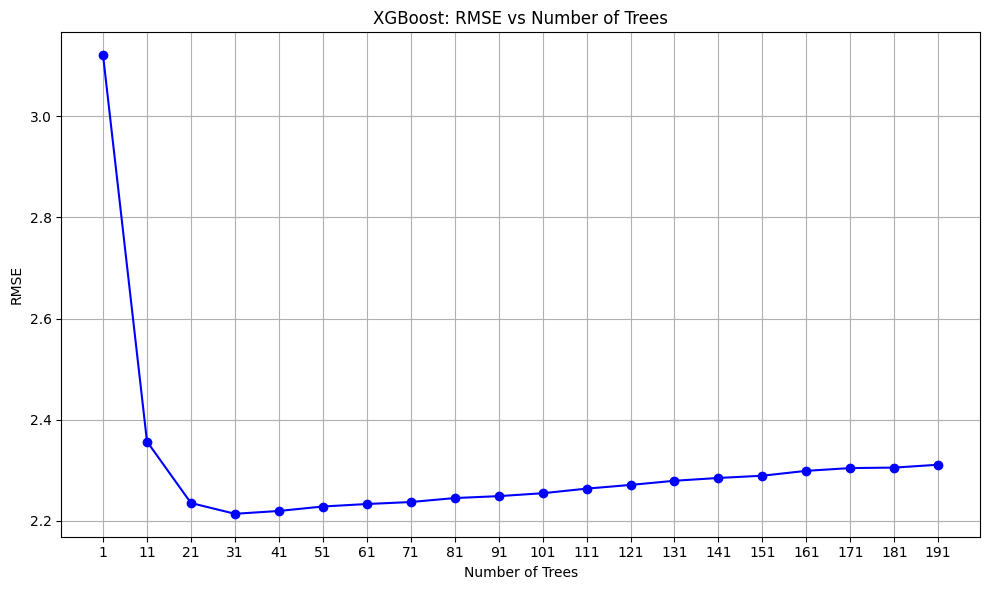

In [24]:
n_estimators_range = range(1, 201, 10)

rmse_values = []
for n_estimators in n_estimators_range:
    model = LGBMRegressor(n_estimators=n_estimators, verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rmse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('XGBoost: RMSE vs Number of Trees')
plt.xticks(n_estimators_range)
plt.grid(True)
plt.tight_layout()
plt.show()

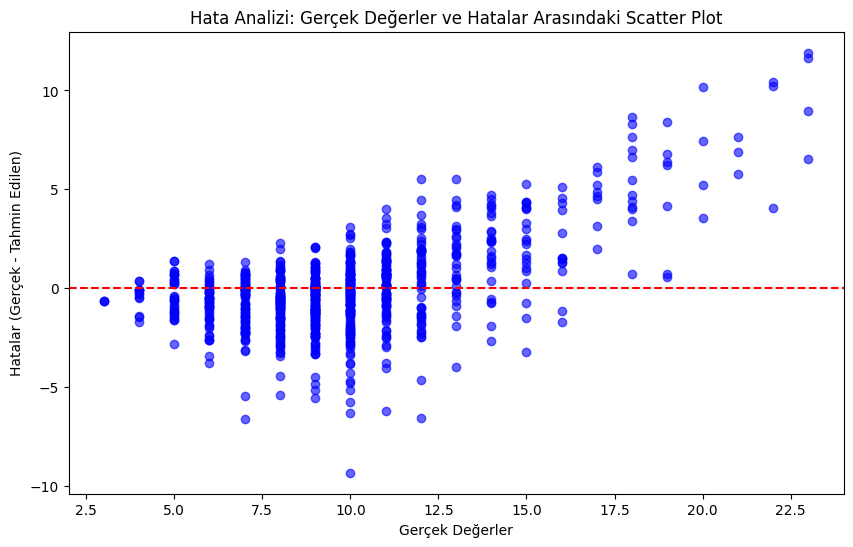

In [25]:
errors = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.6, color='b') 
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Hata Analizi: Gerçek Değerler ve Hatalar Arasındaki Scatter Plot')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Hatalar (Gerçek - Tahmin Edilen)')
plt.show()

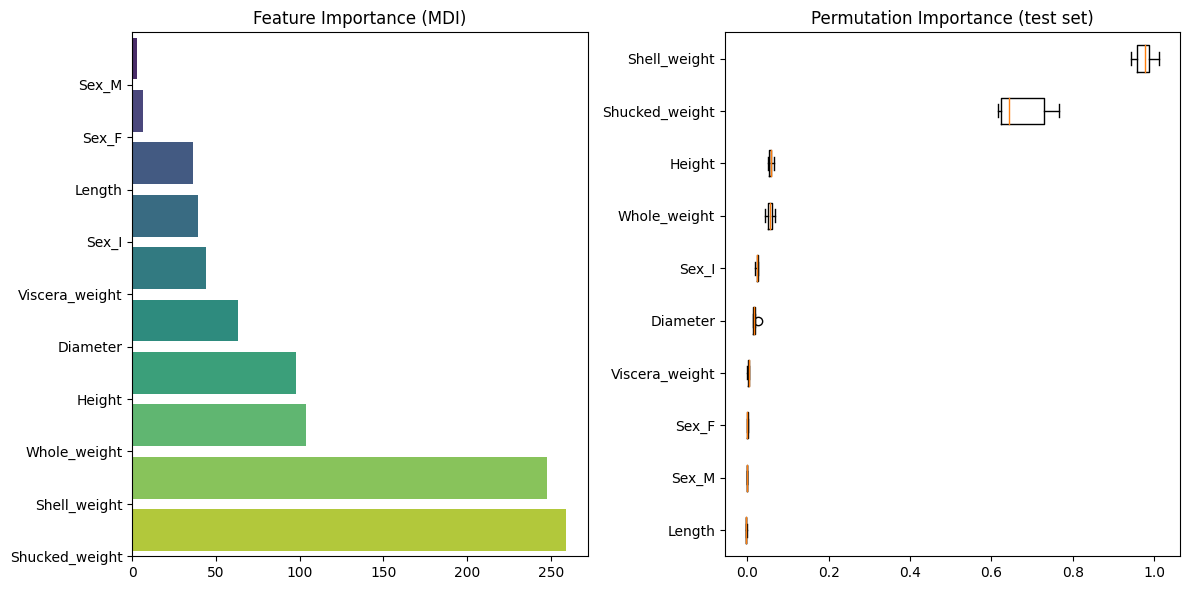

In [26]:
feature_importance = lgb.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=feature_importance[sorted_idx], y=np.array(X_train.columns)[sorted_idx], orient='h', palette='viridis')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    lgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

<Axes: >

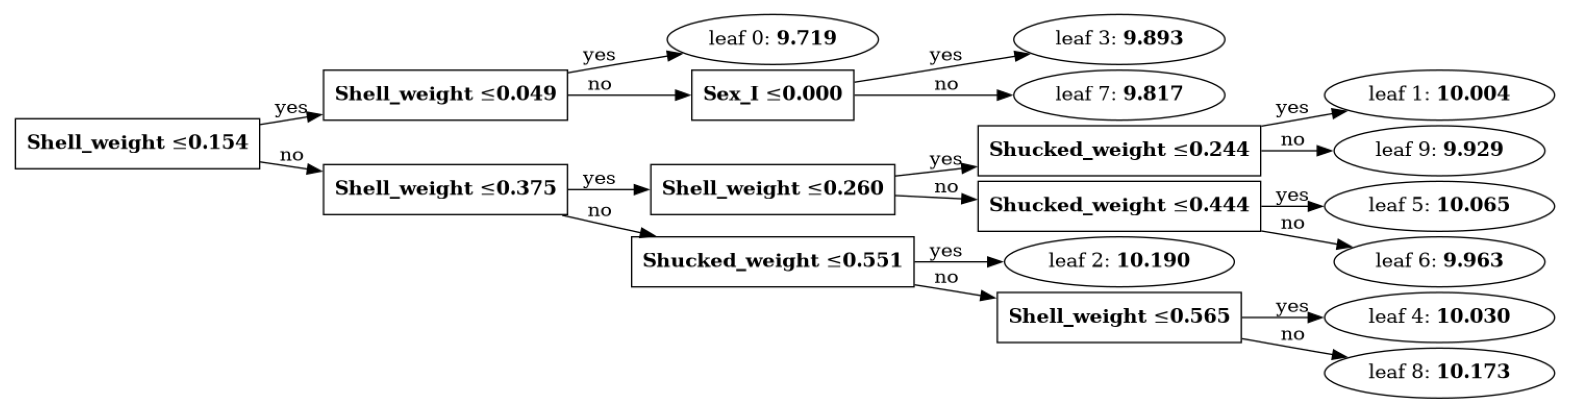

In [27]:
plot_tree(lgb, figsize=(20,10))

## XGBoostRegressor

In [28]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

param_grid = {"n_estimators":[10],
              'max_depth': [5],
              'min_child_weight': [18],
              'reg_alpha': [1.0],
              'subsample': [1.0],
              'colsample_bytree': [1]
             }

grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

xgb_score = cross_val_score(xgb, X_test, y_test, cv = 3, scoring = 'neg_root_mean_squared_error')
print("Test precision:", round(-xgb_score.mean(), 4))

xgb_error = xgb.predict(X_test) - y_test

Best Parameters: {'colsample_bytree': 1, 'max_depth': 5, 'min_child_weight': 18, 'n_estimators': 10, 'reg_alpha': 1.0, 'subsample': 1.0}
Test precision: 2.293


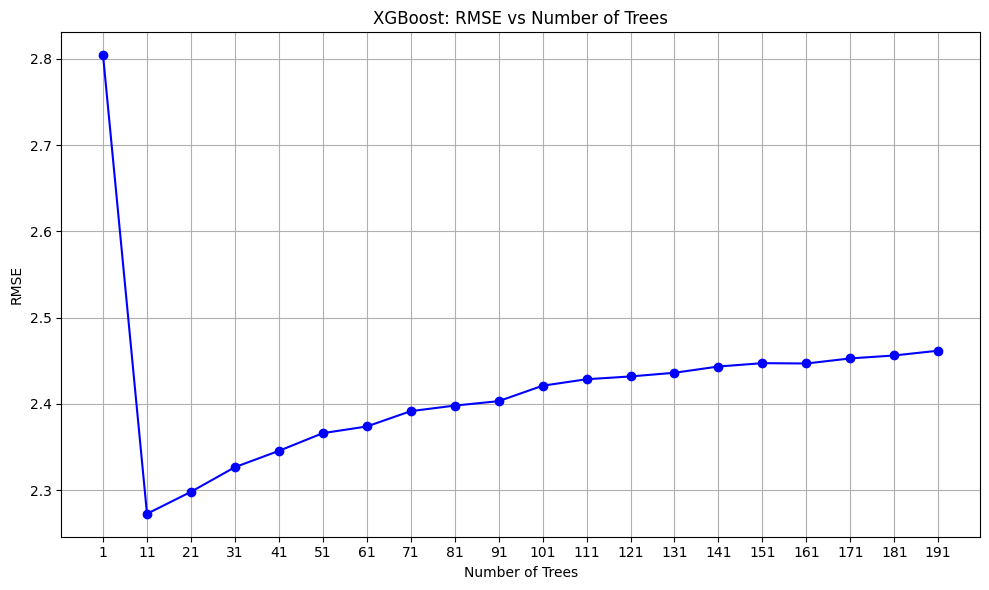

In [29]:
n_estimators_range = range(1, 201, 10)

rmse_values = []
for n_estimators in n_estimators_range:
    model = XGBRegressor(n_estimators=n_estimators, objective='reg:squarederror')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rmse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('XGBoost: RMSE vs Number of Trees')
plt.xticks(n_estimators_range)
plt.grid(True)
plt.tight_layout()
plt.show()

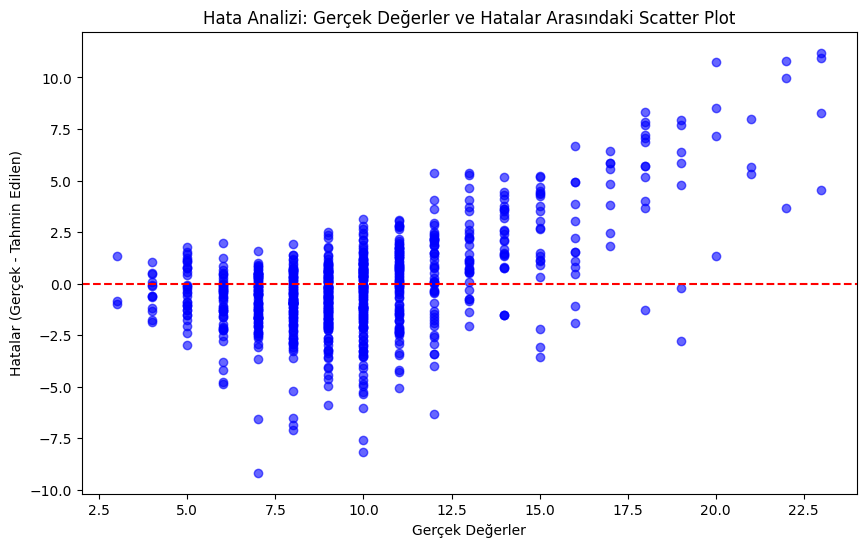

In [30]:
errors = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.6, color='b')  # Gerçek değerler ile hata arasındaki scatter plot
plt.axhline(y=0, color='r', linestyle='--')  # Hata sıfır hattı
plt.title('Hata Analizi: Gerçek Değerler ve Hatalar Arasındaki Scatter Plot')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Hatalar (Gerçek - Tahmin Edilen)')
plt.show()

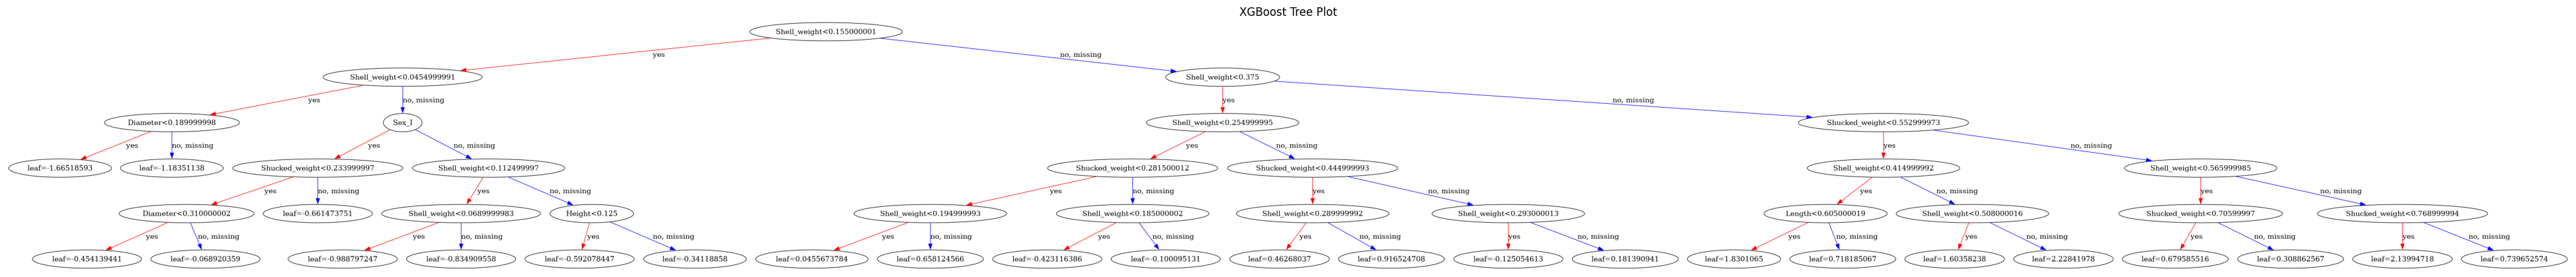

In [31]:
from xgboost import plot_tree as plot_xgb_tree

fig, ax = plt.subplots(figsize=(50, 30))
plot_xgb_tree(xgb, num_trees=0, ax=ax)
plt.title("XGBoost Tree Plot")
plt.show()

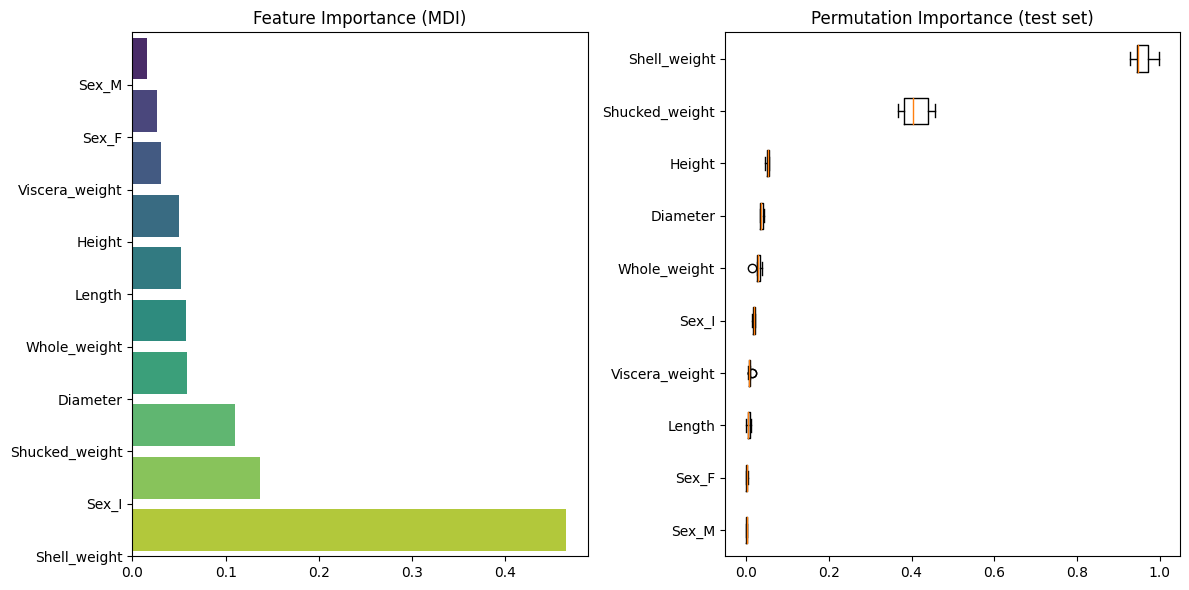

In [32]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=feature_importance[sorted_idx], y=np.array(X_train.columns)[sorted_idx], orient='h', palette='viridis')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Residual Analysis

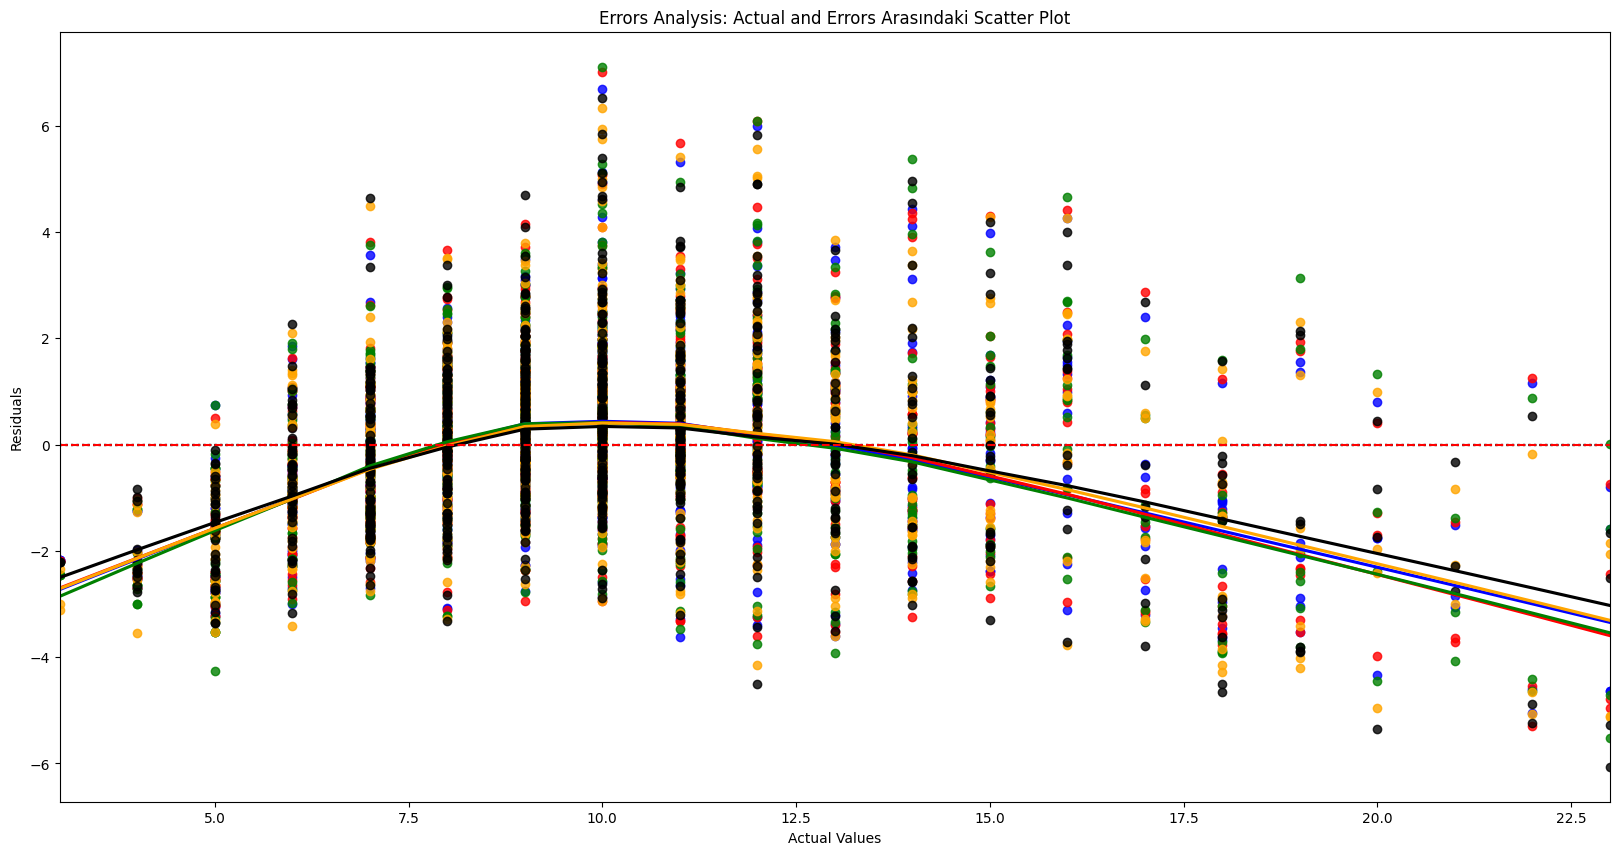

In [33]:
plt.figure(figsize=(20, 10))
sns.residplot(x=y_test, y=lgb_error, lowess=True, line_kws=dict(color="b"), color="b")
sns.residplot(x=y_test, y=xgb_error, lowess=True, line_kws=dict(color="r"), color="r")
sns.residplot(x=y_test, y=gbr_error, lowess=True, line_kws=dict(color="g"), color="g")
sns.residplot(x=y_test, y=rf_error, lowess=True, line_kws=dict(color="orange"), color="orange")
sns.residplot(x=y_test, y=extr_error, lowess=True, line_kws=dict(color="black"), color="black")
plt.axhline(y=0, color='r', linestyle='--')  
plt.title('Errors Analysis: Actual and Errors Arasındaki Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

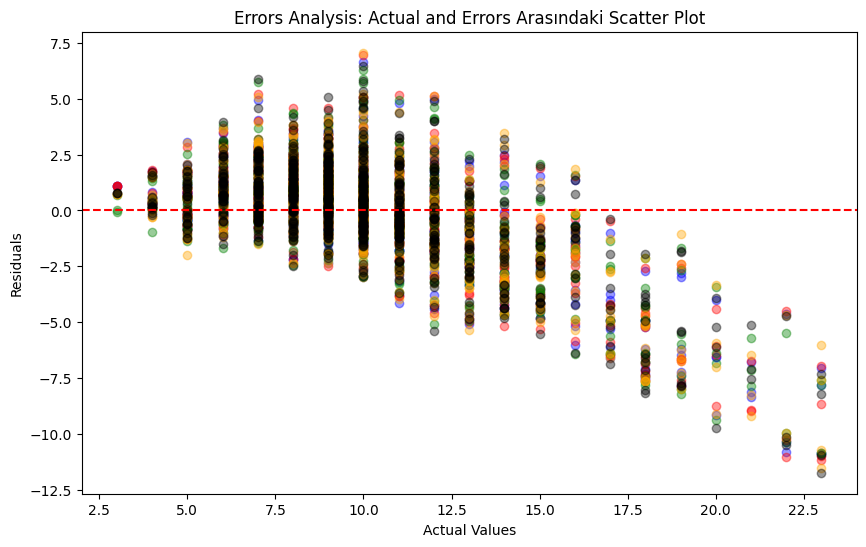

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lgb_error, alpha=0.4, color='b')  
plt.scatter(y_test, xgb_error, alpha=0.4, color='r')  
plt.scatter(y_test, rf_error,  alpha=0.4, color='g')  
plt.scatter(y_test, gbr_error, alpha=0.4, color='orange')  
plt.scatter(y_test, extr_error,alpha=0.4, color='black')  
plt.axhline(y=0, color='r', linestyle='--')  
plt.title('Errors Analysis: Actual and Errors Arasındaki Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

In [35]:
from scipy.stats import f_oneway

models = {
    'LightGBM': lgb,
    'XGBoost': xgb,
    'RandomForest': rf,
    'GradientBoosting': gbr,
    'ExtraTrees': extr
}

errors = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors[model_name] = y_test - y_pred

lgb_error = errors['LightGBM']
xgb_error = errors['XGBoost']
rf_error = errors['RandomForest']
gbr_error = errors['GradientBoosting']
extr_error = errors['ExtraTrees']

anova_result = f_oneway(lgb_error, xgb_error, rf_error, gbr_error, extr_error)

print("ANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic}")
print(f"p-value: {anova_result.pvalue}")

if anova_result.pvalue < 0.05:
    print("Conclusion: There is a significant difference between the groups.")
else:
    print("Conclusion: There is no significant difference between the groups.")

ANOVA Test Results:
F-statistic: 0.009663762597826017
p-value: 0.9998155265876555
Conclusion: There is no significant difference between the groups.



LightGBM for normal distribution test:
Shapiro-Wilk Test: Stat=0.8905, p-değeri=0.0000
Kolmogorov-Smirnov Test: Stat=0.1260, p-değeri=0.0000

XGBoost for normal distribution test:
Shapiro-Wilk Test: Stat=0.8890, p-değeri=0.0000
Kolmogorov-Smirnov Test: Stat=0.1325, p-değeri=0.0000

RandomForest for normal distribution test:
Shapiro-Wilk Test: Stat=0.9007, p-değeri=0.0000
Kolmogorov-Smirnov Test: Stat=0.1150, p-değeri=0.0000

GradientBoosting for normal distribution test:
Shapiro-Wilk Test: Stat=0.9065, p-değeri=0.0000
Kolmogorov-Smirnov Test: Stat=0.1124, p-değeri=0.0000

ExtraTrees for normal distribution test:
Shapiro-Wilk Test: Stat=0.9072, p-değeri=0.0000
Kolmogorov-Smirnov Test: Stat=0.1110, p-değeri=0.0000


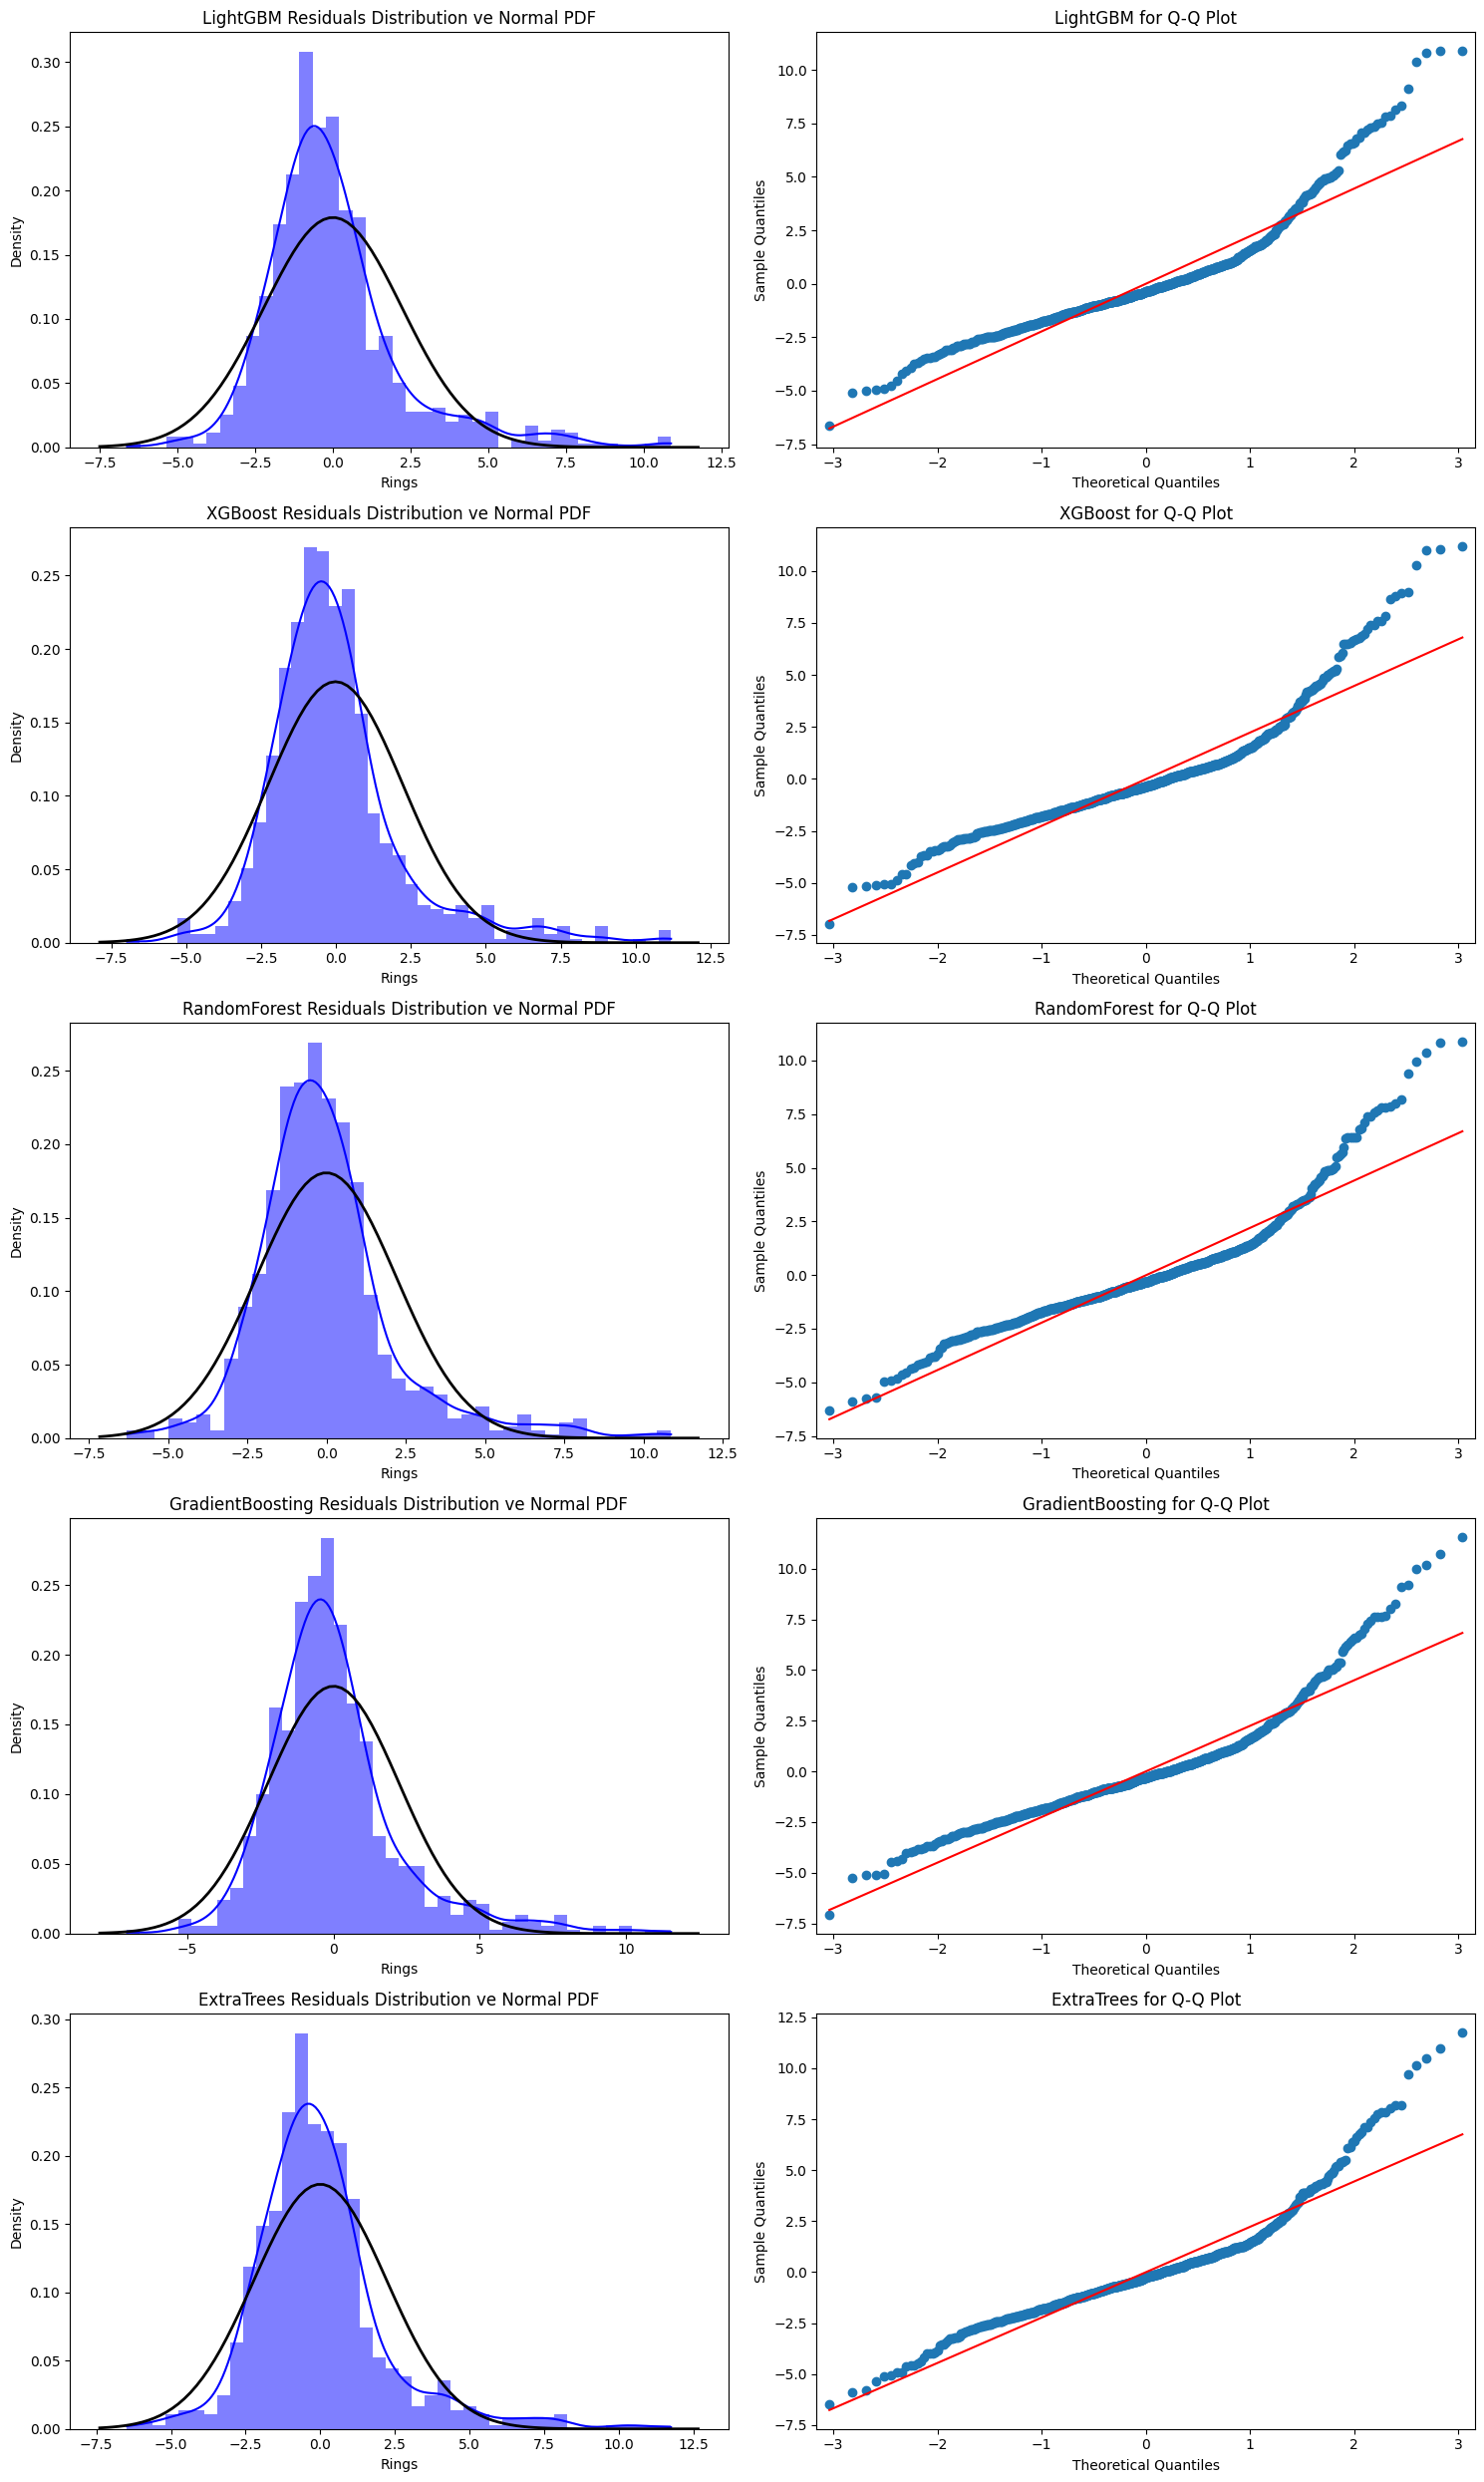

In [36]:
from scipy.stats import shapiro, kstest, norm
from statsmodels.graphics.gofplots import qqplot

models = {
    'LightGBM': lgb,
    'XGBoost': xgb,
    'RandomForest': rf,
    'GradientBoosting': gbr,
    'ExtraTrees': extr
}

errors = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors[model_name] = y_test - y_pred

num_models = len(models)
fig, axs = plt.subplots(num_models, 2, figsize=(15, 5 * num_models))

for i, (model_name, error) in enumerate(errors.items()):
    print(f"\n{model_name} for normal distribution test:")
    
    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = shapiro(error)
    print(f"Shapiro-Wilk Test: Stat={shapiro_stat:.4f}, p-değeri={shapiro_p:.4f}")
    
    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = kstest(error, 'norm', args=(np.mean(error), np.std(error)))
    print(f"Kolmogorov-Smirnov Test: Stat={ks_stat:.4f}, p-değeri={ks_p:.4f}")

    sns.histplot(error, kde=True, stat="density", linewidth=0, color='blue', ax=axs[i, 0])
    mu, std = norm.fit(error)
    xmin, xmax = axs[i, 0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axs[i, 0].plot(x, p, 'k', linewidth=2)
    axs[i, 0].set_title(f"{model_name} Residuals Distribution ve Normal PDF")

    qqplot(error, line='s', ax=axs[i, 1])
    axs[i, 1].set_title(f"{model_name} for Q-Q Plot")

plt.tight_layout()
plt.show()


## Comparating Models

In [37]:

models = {
    'LightGBM': lgb,
    'XGBoost': xgb,
    'RandomForest': rf,
    'GradientBoosting': gbr,
    'ExtraTrees': extr
}

n_estimators_range = range(10, 201, 10)

results = {}
min_rmse_values = {}
for model_name, model in models.items():
    rmse_values = []
    for n_estimators in n_estimators_range:
        model.set_params(n_estimators=n_estimators)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_values.append(rmse)
    results[model_name] = rmse_values
    min_rmse_values[model_name] = min(rmse_values)


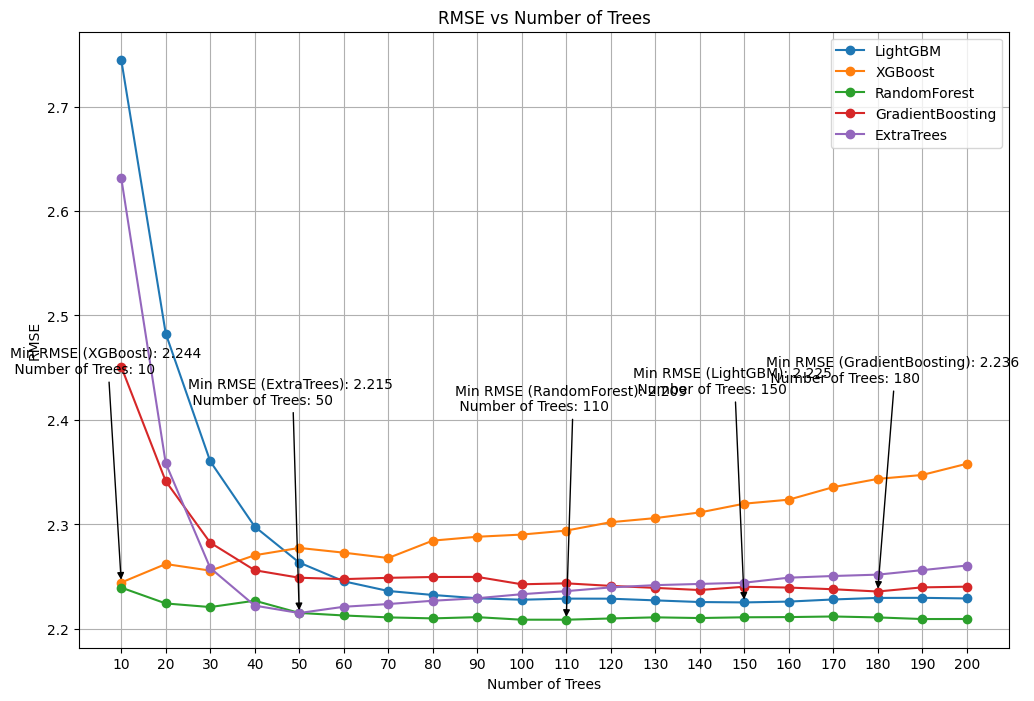

In [38]:
plt.figure(figsize=(12, 8))

for model_name, rmse_values in results.items():
    plt.plot(n_estimators_range, rmse_values, marker='o', label=model_name)

for model_name, min_rmse in min_rmse_values.items():
    min_n_estimators = n_estimators_range[np.argmin(results[model_name])]
    plt.annotate(f'Min RMSE ({model_name}): {min_rmse:.3f} \n Number of Trees: {min_n_estimators}',
                 xy=(min_n_estimators, min_rmse),
                 xytext=(min_n_estimators-25 , min_rmse+0.2),
                 arrowprops=dict(facecolor='black', arrowstyle='-|>'))

plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Trees')
plt.xticks(n_estimators_range)
plt.legend()
plt.grid(True)
plt.show()

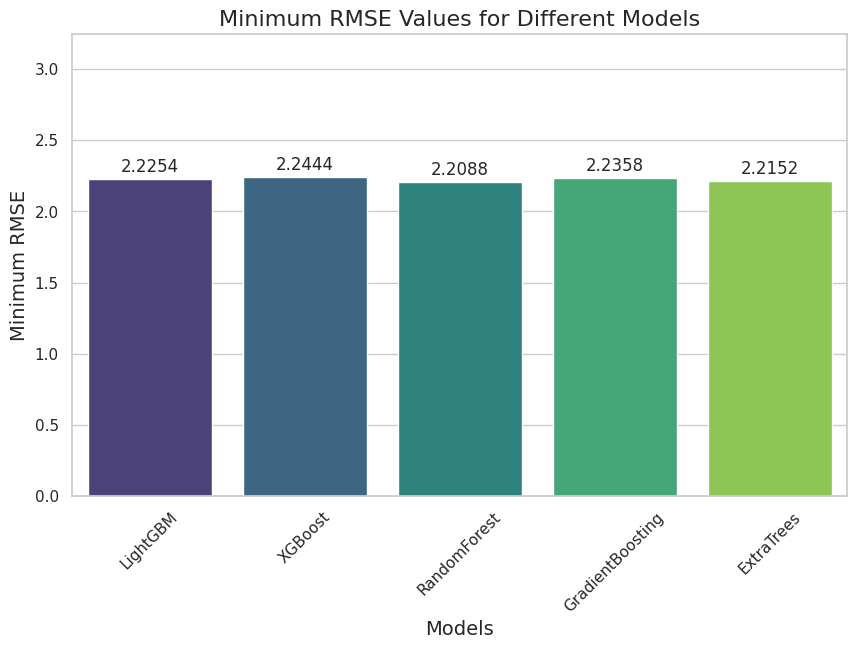

In [39]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x=list(min_rmse_values.keys()), y=list(min_rmse_values.values()), palette='viridis')
plt.xlabel('Models', fontsize=14)
plt.ylabel('Minimum RMSE', fontsize=14)
plt.title('Minimum RMSE Values for Different Models', fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, max(min_rmse_values.values()) + 1)

for i, value in enumerate(min_rmse_values.values()):
    plt.text(i, value + 0.05, f'{value:.4f}', ha='center', fontsize=12)

plt.show()

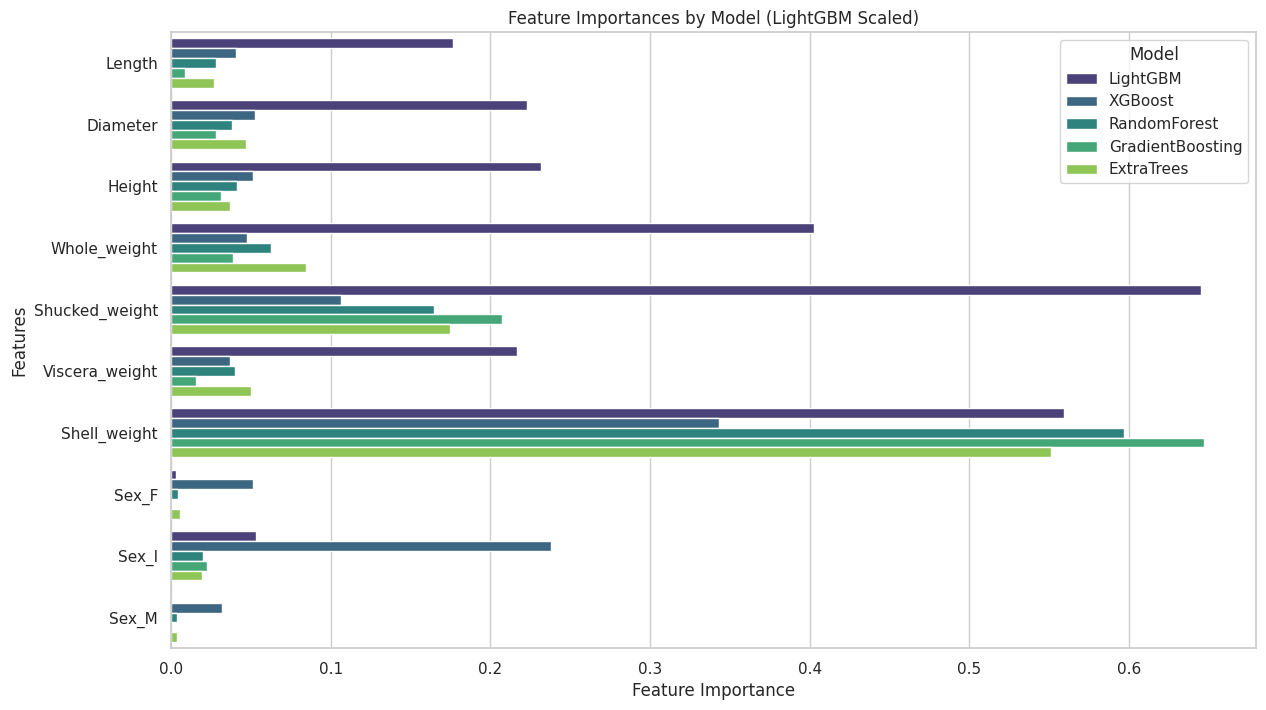

In [40]:
from sklearn.preprocessing import MinMaxScaler


feature_importances_models = {}
for model_name, model in models.items():
    feature_importances_models[model_name] = model.feature_importances_

#max_value = feature_importances_models[feature_importances_models["Feature"] == "Shell_weight"]["Importance"].max()
    
scaler = MinMaxScaler(feature_range=(0, 0.645))
feature_importances_models['LightGBM'] = scaler.fit_transform(feature_importances_models['LightGBM'].reshape(-1, 1)).flatten()

feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns  })

for model_name, importances in feature_importances_models.items():
    feature_importances_df[model_name] = importances


feature_importances_long_df = feature_importances_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')    

plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', hue='Model', data=feature_importances_long_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances by Model (LightGBM Scaled)')
plt.legend(title='Model')
plt.show()

# Building the our Ensemble Model

In [41]:
class EnsembleRegressor:
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=1)

ensemble_model = EnsembleRegressor(models=[rf, xgb, gbr, extr, lgb])
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)
error = y_test-y_pred

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Ensemble model test RMSE : {rmse}")

Ensemble model test RMSE : 2.2206800832879328


In [42]:
def ensemble_predict(models, X, weights=None):
    predictions = np.column_stack([model.predict(X) for model in models])
    if weights is None:
        weights = np.ones(len(models)) / len(models)  
    weighted_predictions = np.dot(predictions, weights)
    return weighted_predictions

weights = np.array([0.2, 0.5, 0.3, 0.5, 0.4])

models=[rf, xgb, gbr, extr, lgb]
ensemble_predictions = ensemble_predict(models, X_test, weights=weights)

rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
print(f"Ensemble model test RMSE : {rmse}")

Ensemble model test RMSE : 9.474343312162755


# Model Transformations

In [43]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from scipy.stats import boxcox

df = pd.read_csv("/kaggle/input/abalone-dataset/abalone.csv")
df.columns = [col.replace(' ', '_') for col in df.columns]
df = pd.get_dummies(df, columns = ['Sex'])
y = df["Rings"]
X = df.drop(["Rings"], axis=1)

# it did not work
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#------------------
#df = np.log(df + 1)  
#------------------
#poly = PolynomialFeatures(degree=2)
#df = poly.fit_transform(df)
#------------------
#y = np.log(y + 1)
#------------------
#y, _ = boxcox(y)
#------------------
#pt = PowerTransformer(method='yeo-johnson')
#y = pt.fit_transform(y.values.reshape(-1, 1))  # Reshape using .values


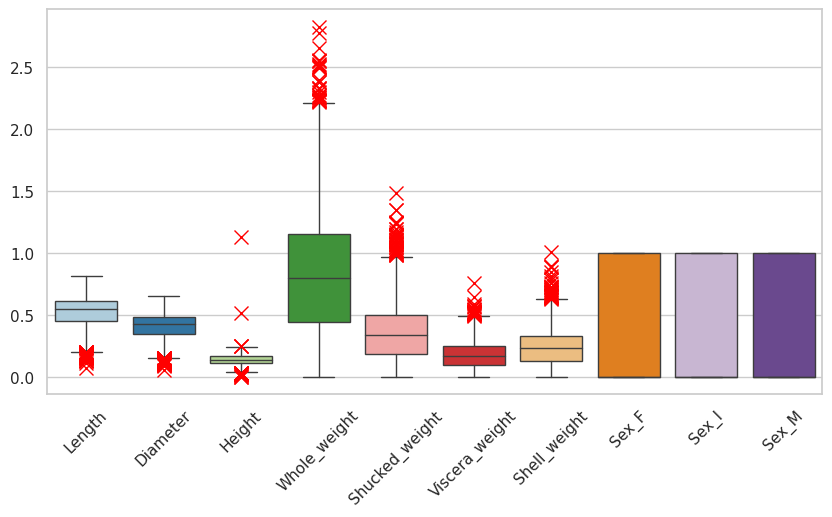

In [44]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
box = sns.boxplot(data=X, palette="Paired", linewidth=1, fliersize = 10 , flierprops={"marker": "x",  "markeredgecolor":"red"})
box.set_xticklabels(labels=box.get_xticklabels(),rotation=45);
plt.show()

In [45]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X)

outliers = model.predict(X) == -1
num_col = ["Length","Diameter","Height","Whole_weight","Shucked_weight","Viscera_weight","Shell_weight"]

for col in X[num_col].columns:
    col_mean = X.loc[~outliers, col].mean()
    X.loc[outliers, col] = col_mean

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


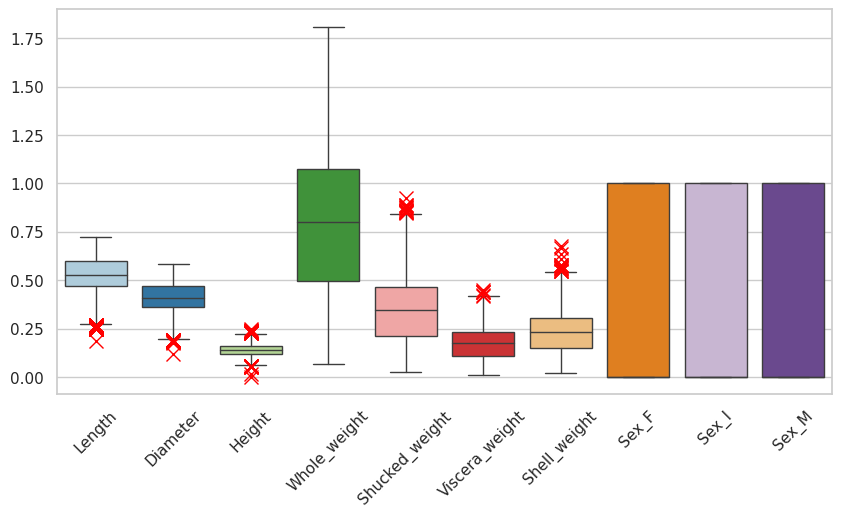

In [46]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
box = sns.boxplot(data=X, palette="Paired", linewidth=1, fliersize = 10 , flierprops={"marker": "x",  "markeredgecolor":"red"})
box.set_xticklabels(labels=box.get_xticklabels(),rotation=45);
plt.show()

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
lgb = LGBMRegressor()

param_grid={"num_leaves":[10,20,30,45],
            "max_depth" :[-1,5,10,15],
            "learning_rate":[0.01,0.05,1],
            "n_estimators":[20,50,80,100,120],
            "random_state":[123],
            "metric":["root_mean_squared_error"],
            "verbose":[-1]
             }
param_grid={"n_estimators":[50] ,"num_leaves":[10], "max_depth" :[5], "learning_rate":[0.05], "n_estimators":[100], "random_state":[123], "metric":["root_mean_squared_error"], "verbose":[-1]}

grid_search = GridSearchCV(estimator = lgb, param_grid = param_grid, cv = 3, scoring = 'neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

lgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

lgb_score = cross_val_score(lgb, X_test, y_test, cv = 3, scoring = 'neg_root_mean_squared_error')
print("Test precision:", round(-lgb_score.mean(), 4))

lgb_error = lgb.predict(X_test) - y_test

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'metric': 'root_mean_squared_error', 'n_estimators': 100, 'num_leaves': 10, 'random_state': 123, 'verbose': -1}
Test precision: 2.4743


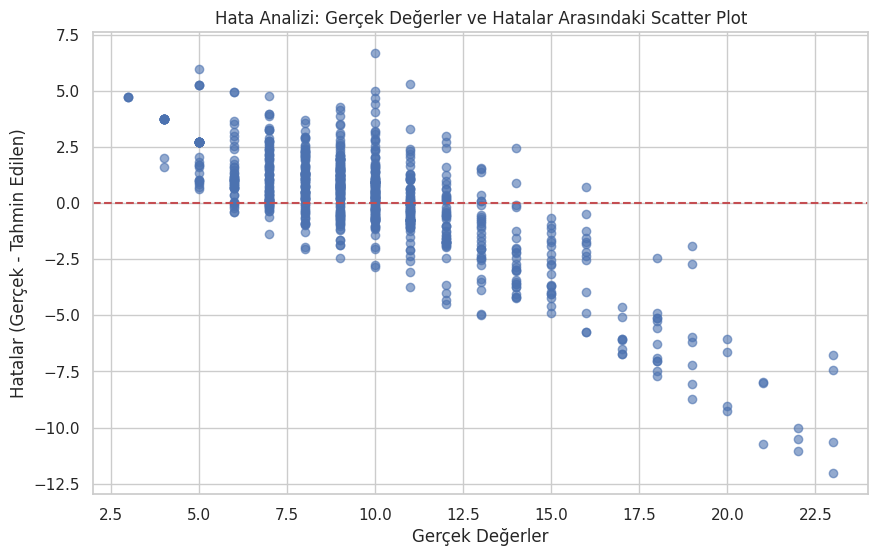

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lgb_error, alpha=0.6, color='b') 
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Hata Analizi: Gerçek Değerler ve Hatalar Arasındaki Scatter Plot')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Hatalar (Gerçek - Tahmin Edilen)')
plt.show()